# A Bayesian Approach to Final Adjusted Values

In this workbook we are going to estimate final adjusted values (FAVs) for a list of compounds using the Bayesian approach outlined in Rodgers et al. (2021). FAVs are physical-chemical property values adjusted for thermodynamic consistency, as each of the properties can be expressed as a combination of the other properties (Cole and Mackay, 2000; Beyer et al., 2002). The properties of interest are as follows:
### Solubilities
Subcooled liquid vapour pressure (PL/Pa) - converted to subcooled liquid air solubility (SAL/mol m-3) as $SAL = PL/RT$ (Cole & Mackay, 2000)<br>
Subcooled liquid water solubilty (SWL/mol m-3)<br>
Subcooled liquid octanol solubility (SOL/mol m-3)
### Dimensionless Partition Coefficients
Octanol/Water partition coefficient (KOW)<br>
Octanol/Air partition coefficient (KOA)<br>
Air/Water partition coefficent (KAW) - can be derived from Henry's law constant (H/Pa m3 mol-1) as $Kaw = H/RT$<br>

The properties are related as:<br>
$logKaw = logSa - logSw$ (1)<br>
$log Koa = logSo - logSa$ (2)<br>
$logKow = logSo - logSw$ (3) (note that this is dry octanol Kow)<br>
$logSo/Sw = logSo-logSw $(4)<br>
From this, we can derive a set of equation which gives the "misclosure error" (w) between the data points, where w is 0 in a completely consistent data set, such as our FAVs, as (Schenker et al., 2005):<br>
$logKaw - logKow + logKoa = w0$ (5)<br>
then we can adjust these values with an adjustment, ei, where (if the relative uncertainty between the values is equal) 
$w0 = e1-e2+e3$ (6) (for the equation above) such that:<br>
$FAVKaw = logKaw-ev1$ (7)<br>
$FAVKow = logKow-e2$ (8)<br>
$FAVKoa = logKoa-e3$ (9)<br>
This system can be extended so that instead of a single equation (5) we have a system of equations, based on (1)-(4) as:<br>
$log(Sa) - log(Sw) -log(Kaw) = w1$ (10)<br>
$log(Sa) - log(So) + log(Koa) = w2$ (11)<br>
$log(Sw) - log(So) + log(Kow) = w3$(12) (note that this is dry octanol Kow)<br>

The temperature dependence of these properties (K or S) can be estimated over a small temperature gradient using a modified Van't Hoff equation as $ln(K/S(T2)) = ln(K/S(T1))- dU/R(1/T2-1/T1)$, where dU is the internal energy of phase change. All values entered into the model should be at 25°C. This paper has used properties corrected from within 5°C of that value (20 - 30 °C, inclusive) to derive the LDVs, unless otherwise noted. 

These internal energy values can also be adjusted, using a similar set of equations to the above (Beyer et al., 2002):<br>
$dUaw - dUow +dUoa = w4$ (13a) or equivalently $dUa - dUw -dUow +dUoa = w4$ (13b).<br>

## Interactive Notebook Overview

This notebook will walk through this approach, providing an open-source tool for anyone familiar with basic Python. This notebook will use the data from Rodgers et al. (2021), which is included with this notebook on Github. Users can replace this with their own data, as long as it follows the same format (or feel free to change the code). We will be making two sets of FAVs here - FAVLs, which are based only on literature measured values, and FAVRs, which supplement the literature measured values with in-silico property estimations where measurements are unavailable, to provide a complete set of recommended values for each compound. 

The layout of this notebook will be as follows:
1. Estimate FAVLs for the internal energies using only literature measured values as priors
    1a. Check consistency, assess bias of adjustments
    1b. Evaluate in-silico estimates vs FAVLs & LDVs (where necessary) to select best in-silico estimations for each property by compound class
2. Estimate FAVRs for the internal energies using LDVs & best in-silico values as priors
    2a. Check consistency, assess bias of adjustments
    2b. Use FAVRs to adjust the partition coefficient and solubility measurements to 298.15 K (not shown, done in Excel)
3. Estimate FAVLs for the partition coefficients & solubilities using only literature measured values as priors
    3a. Check consistency, assess bias of adjustments
    3b. Evaluate in-silico estimates vs FAVLs & LDVs (where necessary) to select best in-silico estimations for each property by compound class
4. Estimate FAVRs for the partition coefficients & solubilites using LDVs & best in-silico values as priors
    4a. Check consistency, assess bias of adjustments
    
Individual cells below can be run by clicking in the cell and pressing shift + enter. More details regarding the Jupyter Notebook interface can be found using the following link: https://jupyter-notebook.readthedocs.io/en/stable/

### Refs: 
Rodgers et al. (2021):<br>
Cole and Mackay, 2000: Cole, J. G. and Mackay, D.: Correlating environmental partitioning properties of organic compounds: The three solubility approach, Environ. Toxicol. Chem., 19(2), 265–270, doi:10.1002/etc.5620190203, 2000.<br>
Beyer et al., 2002: Beyer, A., Wania, F., Gouin, T., Mackay, D. and Matthies, M.: Selecting Internally Consistent Physicochemical Properties of Organic Compounds, Environ. Toxicol. Chem., 21(5), 941–953, doi:10.1002/etc.5620210508, 2002.<br>

## Step 0: Import the Data & Model Functions
The Bayesian FAV Tutorial directory, which contains the Python code (.py extension), must be in the same parent directory as this Jupyter notebook file. You can find the model and all supporting datafiles at https://github.com/tfmrodge/Bayesian_FAV_Tutorial

This project uses some packages that are not part of the standard Anaconda distribtuion. Please follow the instructions at the respective packages' webpages for instructions on how to install: <br>
Uncertainties - https://uncertainties-python-package.readthedocs.io/en/latest/ <br>
PyMC3 (typically included in Conda) - https://docs.pymc.io/

### Editing the Input Files
This notebook relies on two key input files to function. Workbooks are denoted by **bold text** and sheets within workbooks are denoted by *italics*:
1. **LDV_Data** - This file contains the literature derived values from meassured data only. The first four columns give compound identifiers: the class of compounds, the original order they were presented, the compound name, and the compound's CAS number. Next, there are three columns for each property representing the LDV central tendency, standard deviation, and number of literature values for each compound/property pair. The final six columns contain information on the entropy of fusion (dSfus) and the melting point (Tm), neither of which is used in the harmonization process. The **Rodgers et al. SI and Data Template** workbook contains an output spreadsheet that will be automatically populated in the correct format (described below).
2. **LDVMDV_Data** - This file contains the combined in silico and literature derived values (in silico estimations are given a value of 0.5). The first four columns give compound identifiers: the class of compounds, the original order they were presented, the compound name, and the compound's CAS number. Next, there are three columns for each property representing the LDV central tendency, standard deviation, and number of literature values for each compound/property pair. The final six columns contain information on the entropy of fusion (dSfus) and the melting point (Tm), neither of which is used in the harmonization process. The **Rodgers et al. SI and Data Template** workbook contains an output spreadsheet that will be automatically populated in the correct format (described below).

To use this notebook with your own data, the Excel (.xlsx) workbook template provided as **Rodgers et al. SI and Data Template** will guide you through the data entry process and provide formatted outputs that can be copy and pasted into the input data files. A short description of each worksheet and its use follows:
1. *Table S2 Compound Identifiers* - contains a list of all chemicals, along with their compound class and other identifiers. The names, classes & CAS numbers from this sheet are used to generate the LDV_data and LDV_MDV_data output sheets; the other columns are not used further
2. *Table S3 Literature Values* - This sheet contains all of the literature measured values and the Literature Derived Values (LDVs). For each compound, the name should be in the "A" column, with the CAS number and the molecular weight in the B column (CAS above molecular weight). For each property, the leftmost column contains the values that will be pulled into the outputs and so used in this notebook. For each property, the first row contains the central tendency, the second row the standard deviation and the bottom row the number of literature values. To enter your own data, put your own data in each of the properties as per the template. Additional rows can be added without issue but the columns should not be adjusted. The name in the A column is used to pull the data, this must be the same as the name in "Table S2" for the outputs to work.
3. *Table S4 Conversions and Notes* - This sheet contains the calculations used to generate the LDVs. The top table contains the calculations for the fugacity ratio (F), based on the dSfus LDVs in "Table S3" or a default value. The table below contains temperature conversions (to 298K from the temperature of measurement) and the subcooled-liquid state conversions using the fugacity ration calculated above. 
4. *Table S5 Measurement References* - This table contains the references for the literature measurements in Table S3. This is for reference; these entries do not impact any calculations.
5. *Table S6 Recommended Values* - This table contains the FAVLs, the FAVRs, the LDVs and the Model Derived Values (MDVs). This table must be updated manually.
6. *Table S9 Model Derived Values* - This contains the model derived values (MDVs). These must be input in the same manner as the LDVs.
7. *LDV Output* - This contains the output data for the LDVs, used to calculate the literature FAVs (FAVLs). It is linked to Table S3, and is the input for this notebook. The compound names are linked to Table S2. To use this data, copy and paste the values into the **LDV_Data** workbook.
8. *LDV_MDV Output* - This contains the output data for the MDVs and LDVs, used to calculate the recommended FAVs (FAVRs). It is linked to Table S3, and is the input for the "part 2" notebook. To use this data, copy and paste the values into the **LDVMDV_Data** workbook.

In [1]:
#Import necessary Python packages
import uncertainties
import pandas as pd
import pymc3 as pm
import pdb
import os
from IPython.core.interactiveshell import InteractiveShell
#This contains the FAV model set-up and display functions. For more details or for help with variable names
#etc, look at the function definitions and comments. The "FAV_model_funcs.py" file must be in the same
#folder as this notebook
import FAV_model_funcs as fmf
#Load Data
LDV = pd.read_excel('LDV_Data.xlsx', index_col = 2)
uLDV,FAVs = fmf.loaddata(LDV)
#Display the header column of the uLDV.
#uLDV.head()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Step 1: Estimate FAVLs for the internal energies
First, we will calculate the literature-only FAVs (FAVLs) for the internal energies. To start off we will look at what properties are missing from the different compounds. This was calculated in the loaddata function, Below, we have limited to <3 properties missing, as generating an FAV requires at least 3 properties (or more, depending on which properties are present)

In [4]:
#Define the number of missing enthalpies to display
numUs_absent = 3
uLDV.loc[uLDV.nUs_absent<=numUs_absent,'dUA_absent':'dUOA_absent']
#We can make FAVLs for most of these compounds, B[a}P is onl missing one propery

dUA_absent  dUW_absent  dUO_absent  dUAW_absent  \
Compound Name                                                           
Musk Ambrette              False       False        True         True   
Celestolide                 True       False        True         True   
Phantolide                 False       False        True         True   
Traseolide                 False       False        True         True   
Moskene                    False        True        True         True   
Tonalide                    True       False        True         True   
Galaxolide 1               False       False        True         True   
Musk Tibetene              False       False        True         True   
p,p'- DDE                  False       False       False         True   
o,p'-DDD                   False       False        True         True   
p,p'-DDD                   False       False        True         True   
o,p'-DDT                   False       False       False         True   
aldrin                     False       False        True         True   
benzo[a]pyrene             False       False       False         True   
BDE-47                     False       False        True         True   
BDE-99                     False       False        True         True   
PCB-19                     False       False        True         True   
PCB-119                    False       False        True         True   
PCB-47                     False       False        True         True   
PCB-209                    False       False        True         True   
Di-n-butyl phthalate       False       False        True         True   

                      dUOW_absent  dUOA_absent  
Compound Name                                   
Musk Ambrette               False        False  
Celestolide                 False        False  
Phantolide                  False        False  
Traseolide                  False        False  
Moskene                     False        False  
Tonalide                    False        False  
Galaxolide 1                False        False  
Musk Tibetene               False        False  
p,p'- DDE                    True        False  
o,p'-DDD                     True        False  
p,p'-DDD                     True        False  
o,p'-DDT                     True        False  
aldrin                       True        False  
benzo[a]pyrene              False        False  
BDE-47                      False        False  
BDE-99                       True        False  
PCB-19                       True        False  
PCB-119                      True        False  
PCB-47                       True        False  
PCB-209                     False        False  
Di-n-butyl phthalate         True        False

In [2]:
#Now, we will set up and run our Bayesian model! 
#Here we will do B[a}P, where we are only missing one property.
#This will solve the following set of equations, using the LDV mean and standard deviation as the priors.
#dUa - dUW - dUAW = 0 [1 -1 -1 0 0] = 0
#dUw - dUo + dUOW = 0 [0 1 -1 0 1 0] = 0
#dUa - dUo + dUoa = 0 [1 0 -1 0 0 1] = 0
comp = 'benzo[a]pyrene'
#This function will set up and run the Bayesian model. 
FAVs, enth_trace = fmf.run_model(comp,FAVs,uDV = uLDV,model_type='dU',trace = 100, tune=100)
#Running the model gives an animated display of your progress - be cautious, this can be slow if the number of 
#samples is high (number of samples = tune+trace)

D:\GitHub\Bayesian_FAV_Tutorial\FAV_model_funcs.py:326: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FAV_trace = pm.sample(trace,tune=tune,chains=chains,cores=cores,target_accept=target_accept,max_treedepth=max_treedepth)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [dUOA, dUOW, dUAW, dUO, dUW, dUA, sigma]


Sampling 5 chains for 100 tune and 100 draw iterations (500 + 500 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.960082616271091, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\trodge01\Anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\trodge01\Anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
dUA    107.068  3.147  100.583  112.139      0.258    0.184     152.0   
dUW     32.062  4.583   22.507   40.061      0.461    0.327     101.0   
dUO      6.776  2.266    2.569   10.910      0.159    0.115     209.0   
dUOW   -25.290  4.233  -31.934  -16.240      0.408    0.289     109.0   
dUOA  -100.272  2.227 -104.819  -96.809      0.203    0.144     122.0   
sigma    0.124  0.063    0.032    0.255      0.005    0.003      94.0   
dUAW    75.008  4.704   67.033   84.161      0.464    0.329     102.0   

       ess_tail  r_hat  
dUA       207.0   1.04  
dUW       117.0   1.04  
dUO       238.0   1.00  
dUOW      168.0   1.04  
dUOA      245.0   1.06  
sigma     110.0   1.05  
dUAW      174.0   1.04

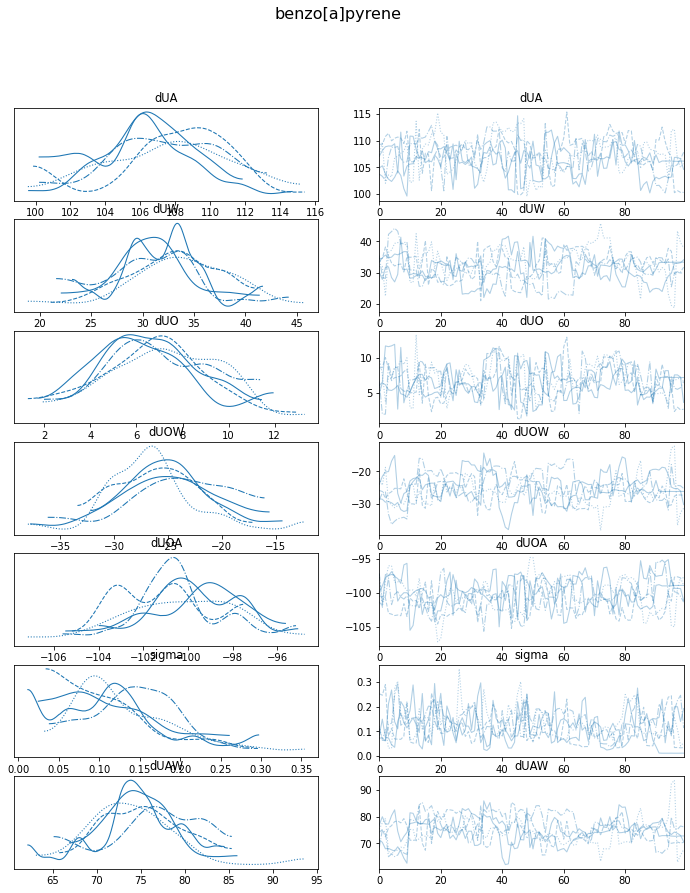

In [3]:
#To assess convergence, we will display the "traceplot" and a summary table. 
#These first lines sets jupyter so that the traceplots and summary tables will be displayed together
InteractiveShell.ast_node_interactivity = "all"
comp = 'benzo[a]pyrene'
#To run this, you must run the cell above first as it calls "enth_trace" that is generated by that cell.
fig, tracesumm = fmf.plot_trace(comp,FAVs,enth_trace,uDV = uLDV,model_type = 'dU')
tracesumm
#We want the number of effective samples (ess_bulk) to be high - generally, if for all variables it is >5000 
#the model converged, otherwise it is worth inspecting the traceplot to ensure that the on the left-hand figures
#the lines (each representing one "chain" overlap, and on the right-hand figure the chains look similar/overlap

In [8]:
#Restore the interactice shell to default.
InteractiveShell.ast_node_interactivity = 'last_expr'   

Now that we have the hang of running the model, we will loop through all of our compounds with >3 properties,
generating FAVs for all where it is possible. In some cases even with >3 properties it won't be possible
e.g. if you have dUA, dUW and dUo there is no way to get a misclosure error, and therefore we won't calculate FAVs
Note that runnning a lot of compounds will take a lot of time - hours per compound with lots of samples

In [4]:
#Define the compounds that will be tried - here we loop through everything with more than three properties.
numUs_absent = 3
comps = uLDV[uLDV.nUs_absent<=numUs_absent].index
#If you want to run a specific compound/list of compounds, comment out the above line and run the following:
comps = ['Musk Ambrette']
for comp in comps:
    #pdb.set_trace()
    #For some compounds we can't make an FAV. This will raise a "ValueError", and we will skip that compound.
    try:
        FAVs, enth_trace = fmf.run_model(comp,FAVs,model_type ='dU',uDV = uLDV,trace = 100, tune=100,target_accept=0.9)
    except ValueError:
        pass

D:\GitHub\Bayesian_FAV_Tutorial\FAV_model_funcs.py:326: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FAV_trace = pm.sample(trace,tune=tune,chains=chains,cores=cores,target_accept=target_accept,max_treedepth=max_treedepth)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [dUOA, dUOW, dUAW, dUW, dUA, sigma]


Sampling 5 chains for 100 tune and 100 draw iterations (500 + 500 draws total) took 25 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
#For some reason this needs to be done outside of the cell.
InteractiveShell.ast_node_interactivity = 'all' 

'BDE-47'

mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    88.849  4.123   81.960   96.763      0.924    0.664      20.0    20.0   
dUW    15.812  2.310   10.852   20.238      0.249    0.177      86.0    86.0   
dUOW  -21.511  3.455  -25.971  -14.260      0.571    0.407      37.0    37.0   
dUOA  -94.557  3.948 -102.432  -87.844      0.566    0.403      49.0    49.0   
sigma   0.070  0.059    0.003    0.182      0.013    0.009      20.0    20.0   
dUAW   73.046  4.843   65.526   82.036      1.200    0.864      16.0    16.0   

       ess_bulk  ess_tail  r_hat  
dUA        20.0      99.0   1.19  
dUW        82.0     174.0   1.13  
dUOW       48.0     181.0   1.08  
dUOA       43.0     125.0   1.14  
sigma      11.0      12.0   1.41  
dUAW       15.0      29.0   1.27

'benzo[a]pyrene'

mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    107.580  3.723  101.250  114.424      0.260    0.184     205.0   205.0   
dUW     31.958  5.008   22.521   40.750      0.458    0.325     120.0   120.0   
dUO      7.025  2.807    1.994   12.976      0.218    0.160     166.0   155.0   
dUOW   -24.918  4.706  -33.611  -15.901      0.372    0.264     160.0   160.0   
dUOA  -100.572  2.602 -105.628  -95.992      0.165    0.117     249.0   249.0   
sigma    0.106  0.058    0.016    0.209      0.005    0.003     156.0   156.0   
dUAW    75.631  5.072   67.029   85.605      0.346    0.247     215.0   211.0   

       ess_bulk  ess_tail  r_hat  
dUA       208.0     254.0   1.03  
dUW       117.0     107.0   1.05  
dUO       168.0     160.0   1.02  
dUOW      162.0     123.0   1.02  
dUOA      252.0     211.0   1.03  
sigma     110.0     121.0   1.05  
dUAW      215.0     196.0   1.01

'Galaxolide 1'

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    83.493  1.785  80.281   86.889      0.139    0.099     165.0   165.0   
dUW    13.905  3.123   7.447   19.082      0.283    0.201     122.0   122.0   
dUOW   -1.378  2.553  -5.926    3.263      0.250    0.182     104.0    99.0   
dUOA  -70.975  1.414 -73.478  -68.467      0.139    0.099     103.0   103.0   
sigma   0.077  0.055   0.006    0.174      0.007    0.005      62.0    62.0   
dUAW   69.604  2.804  64.697   75.010      0.332    0.235      71.0    71.0   

       ess_bulk  ess_tail  r_hat  
dUA       163.0     222.0   1.01  
dUW       125.0     100.0   1.06  
dUOW      105.0     120.0   1.04  
dUOA      112.0     259.0   1.04  
sigma      33.0      43.0   1.12  
dUAW       75.0      62.0   1.06

'Musk Ambrette'

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    87.247   9.138  71.258  104.766      0.809    0.597     128.0   118.0   
dUW    28.097  11.670   6.408   50.254      1.103    0.782     112.0   112.0   
dUOW   -7.441  10.578 -25.673   12.311      1.191    0.845      79.0    79.0   
dUOA  -66.587   5.681 -78.829  -57.886      0.407    0.298     195.0   183.0   
sigma   0.087   0.059   0.010    0.196      0.005    0.003     156.0   156.0   
dUAW   59.145  10.884  37.881   77.415      1.095    0.800      99.0    93.0   

       ess_bulk  ess_tail  r_hat  
dUA       133.0     157.0   1.04  
dUW       106.0     147.0   1.02  
dUOW       84.0      55.0   1.04  
dUOA      218.0     155.0   1.02  
sigma     116.0     159.0   1.02  
dUAW      101.0     142.0   1.04

'Musk Tibetene'

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    93.572  5.524  82.590  101.264      1.315    0.950      18.0    17.0   
dUW    15.752  4.836   6.651   24.627      0.393    0.284     151.0   145.0   
dUOW    2.285  3.694  -4.066    8.611      0.606    0.432      37.0    37.0   
dUOA  -75.547  1.824 -78.364  -71.741      0.206    0.146      79.0    79.0   
sigma   0.083  0.061   0.003    0.191      0.015    0.011      17.0    17.0   
dUAW   77.817  4.143  71.046   85.104      0.860    0.629      23.0    22.0   

       ess_bulk  ess_tail  r_hat  
dUA        20.0      93.0   1.21  
dUW       155.0     106.0   1.05  
dUOW       39.0     241.0   1.10  
dUOA       78.0     196.0   1.05  
sigma      13.0      22.0   1.34  
dUAW       27.0     195.0   1.14

"o,p'-DDT"

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    86.697  0.974  85.014   88.488      0.155    0.111      39.0    39.0   
dUO     2.702  1.026   1.135    4.498      0.233    0.184      19.0    16.0   
dUOA  -84.006  0.742 -85.547  -82.820      0.131    0.094      32.0    32.0   
sigma   0.047  0.050   0.001    0.138      0.009    0.006      31.0    31.0   

       ess_bulk  ess_tail  r_hat  
dUA        37.0     193.0   1.10  
dUO        20.0      50.0   1.19  
dUOA       38.0      51.0   1.09  
sigma      18.0      43.0   1.22

"p,p'- DDE"

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    79.070  1.936  75.116   81.947      0.204    0.146      90.0    88.0   
dUO    -5.333  2.097  -9.540   -1.372      0.188    0.133     125.0   125.0   
dUOA  -84.385  2.127 -88.190  -80.181      0.217    0.154      96.0    96.0   
sigma   0.055  0.055   0.001    0.153      0.008    0.005      51.0    51.0   

       ess_bulk  ess_tail  r_hat  
dUA       104.0     279.0   1.04  
dUO       127.0     150.0   1.08  
dUOA       95.0     140.0   1.04  
sigma      16.0      18.0   1.27

'PCB-209'

mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    101.850  1.321   99.642  104.448      0.082    0.058     262.0   262.0   
dUW     30.202  5.048   20.639   39.600      0.433    0.308     136.0   135.0   
dUOW   -27.075  4.044  -33.383  -18.235      0.293    0.209     191.0   188.0   
dUOA   -98.744  4.800 -106.822  -89.308      0.547    0.388      77.0    77.0   
sigma    0.081  0.054    0.003    0.180      0.004    0.003     201.0   201.0   
dUAW    71.656  4.993   62.651   80.941      0.413    0.293     146.0   146.0   

       ess_bulk  ess_tail  r_hat  
dUA       261.0     249.0   1.01  
dUW       135.0     140.0   1.05  
dUOW      188.0     270.0   1.02  
dUOA       76.0     136.0   1.06  
sigma     146.0     118.0   1.02  
dUAW      149.0     162.0   1.04

'Phantolide'

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    61.224  5.331  51.082   70.350      0.430    0.305     153.0   153.0   
dUW   -14.301  5.461 -23.424   -3.560      0.462    0.334     140.0   134.0   
dUOW    6.255  4.785  -3.359   14.038      0.603    0.428      63.0    63.0   
dUOA  -69.257  5.087 -79.860  -60.602      0.364    0.257     196.0   196.0   
sigma   0.092  0.064   0.004    0.207      0.005    0.004     168.0   168.0   
dUAW   75.531  5.887  65.140   85.361      0.419    0.297     197.0   197.0   

       ess_bulk  ess_tail  r_hat  
dUA       153.0     157.0   1.01  
dUW       139.0     209.0   1.03  
dUOW       67.0     251.0   1.06  
dUOA      191.0     193.0   1.03  
sigma     128.0     194.0   1.05  
dUAW      195.0     247.0   1.02

'Traseolide'

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
dUA    62.825   9.791  45.815   81.580      1.059    0.755      86.0    85.0   
dUW   -25.777   9.383 -42.539   -6.556      0.790    0.560     141.0   141.0   
dUOW   11.836  10.281  -5.241   30.379      0.964    0.683     114.0   114.0   
dUOA  -76.770  10.035 -94.670  -59.648      0.751    0.534     178.0   177.0   
sigma   0.096   0.060   0.015    0.210      0.004    0.003     218.0   218.0   
dUAW   88.612   9.894  69.024  105.663      1.169    0.830      72.0    72.0   

       ess_bulk  ess_tail  r_hat  
dUA        82.0     171.0   1.05  
dUW       146.0     185.0   1.02  
dUOW      104.0     212.0   1.06  
dUOA      178.0     226.0   1.03  
sigma     152.0      81.0   1.02  
dUAW       73.0     219.0   1.07

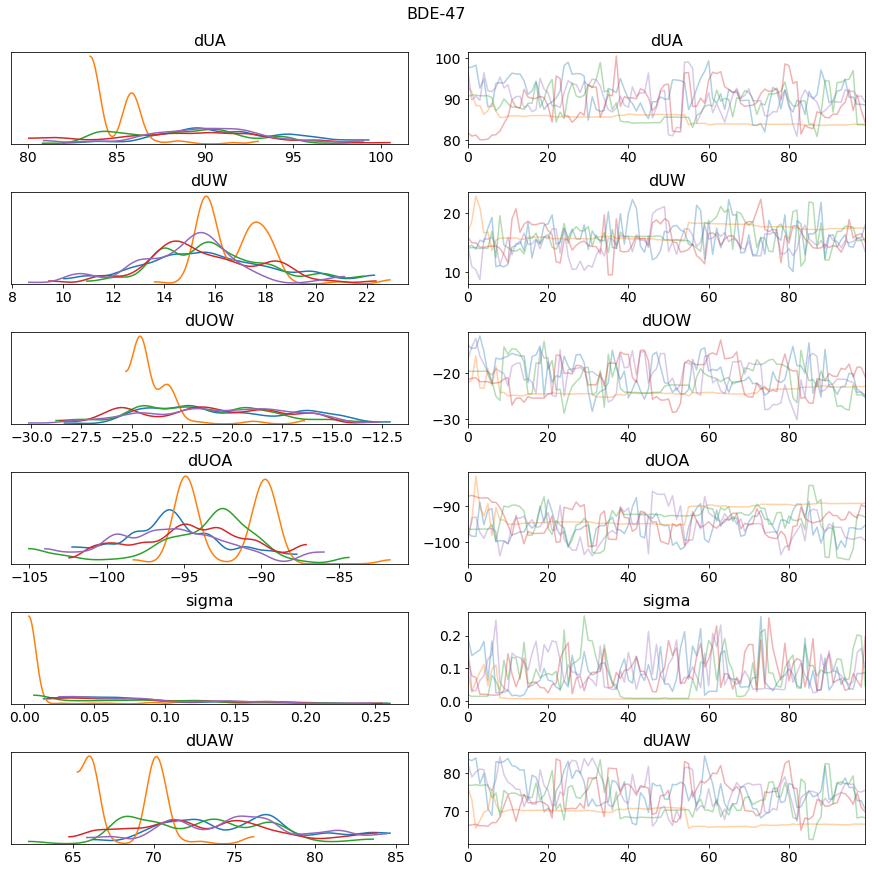

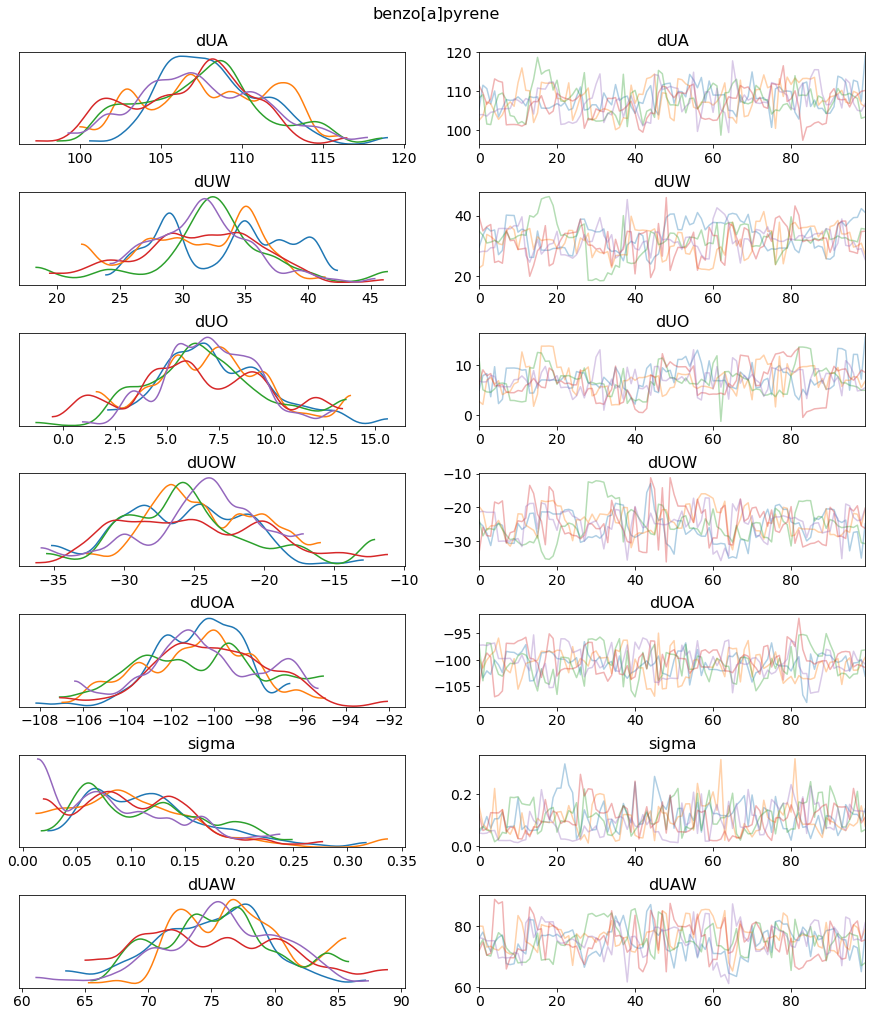

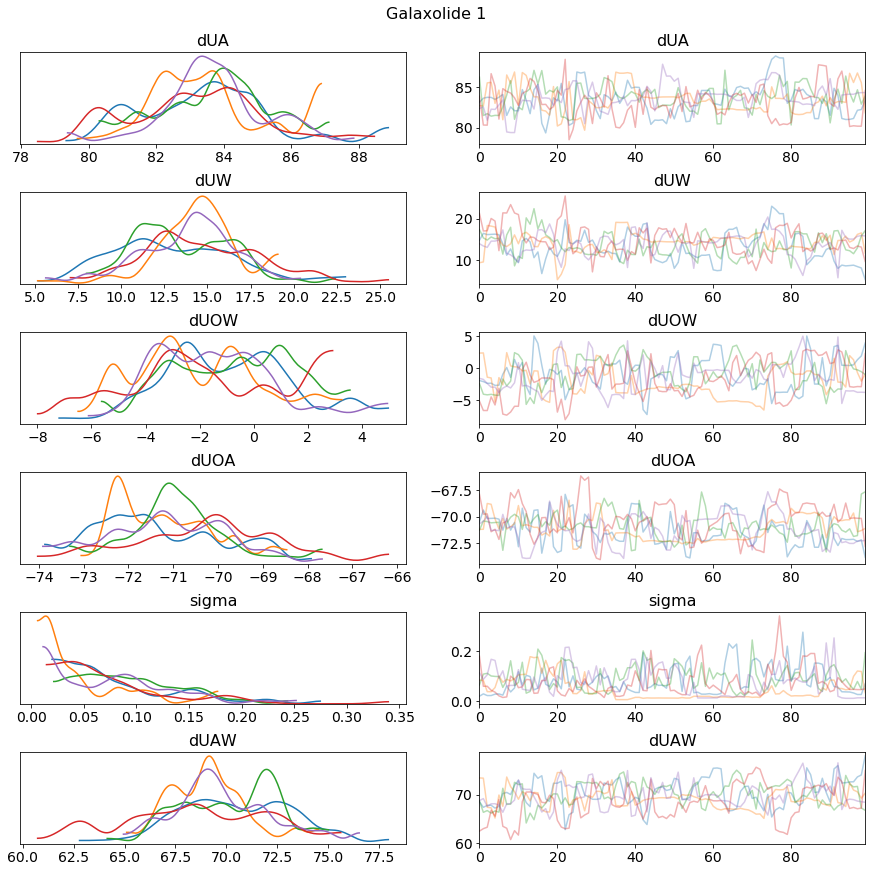

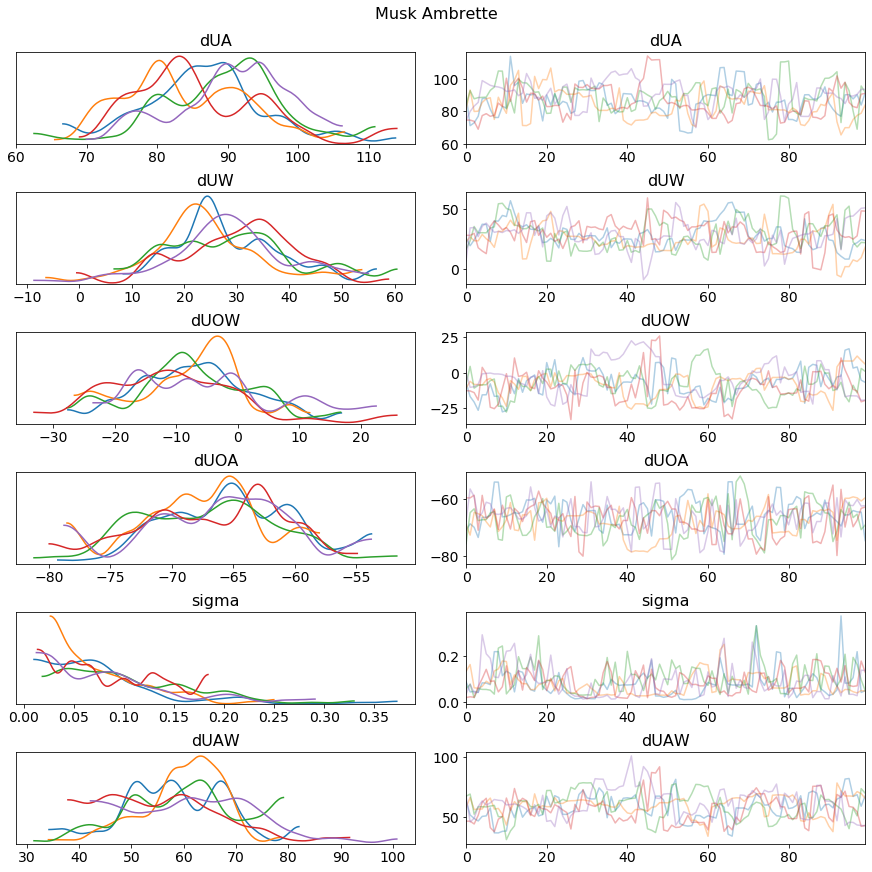

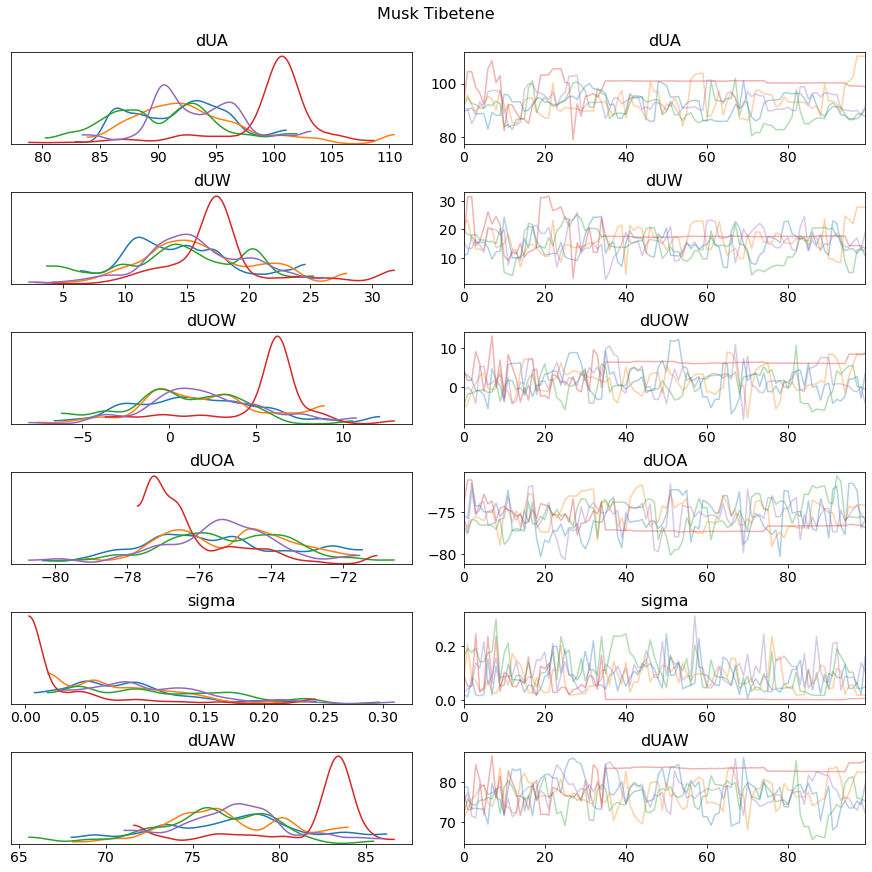

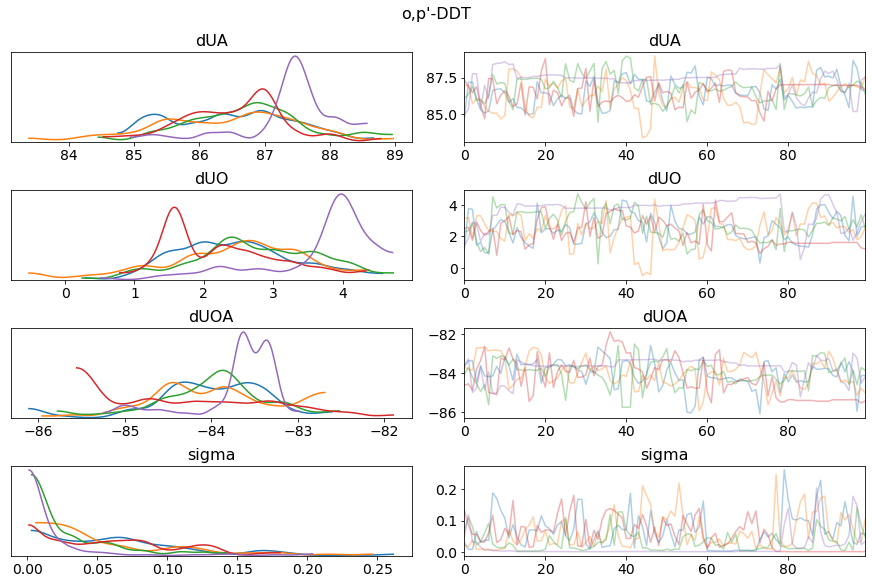

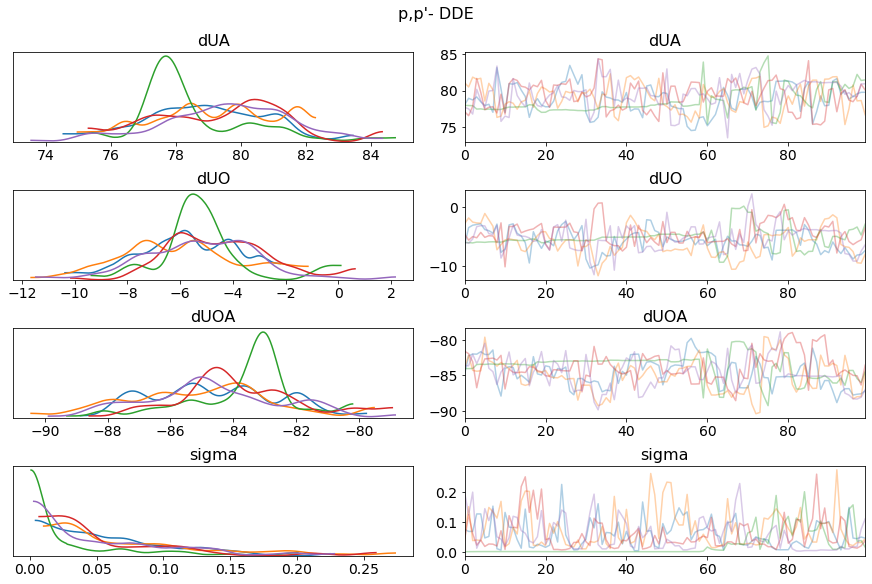

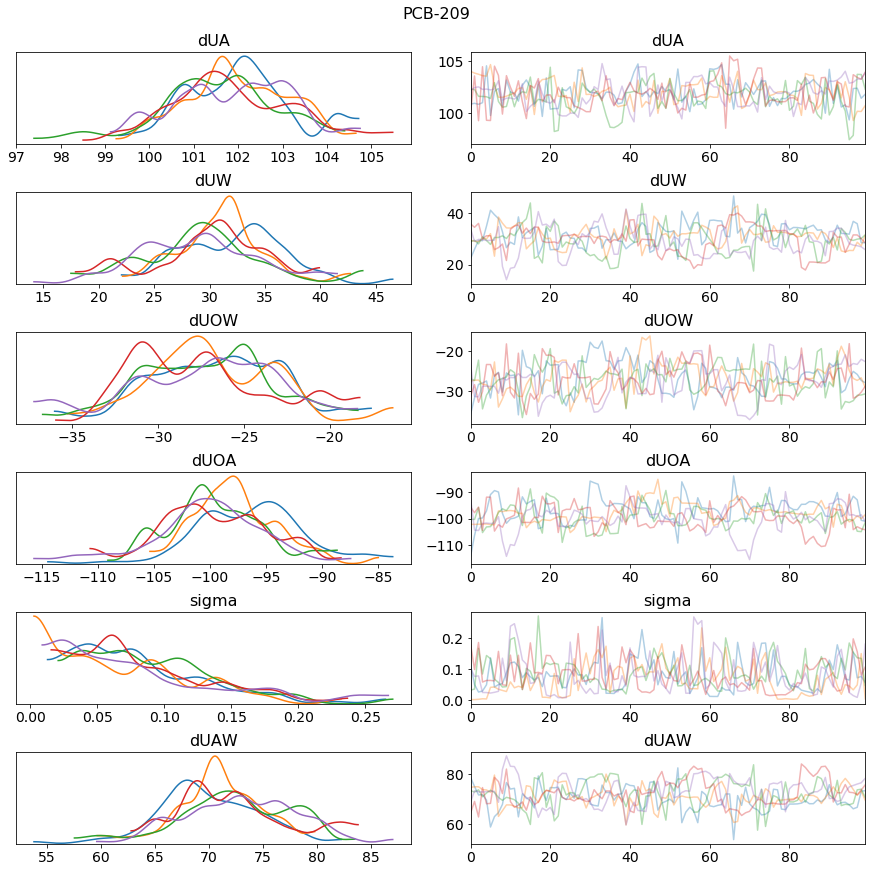

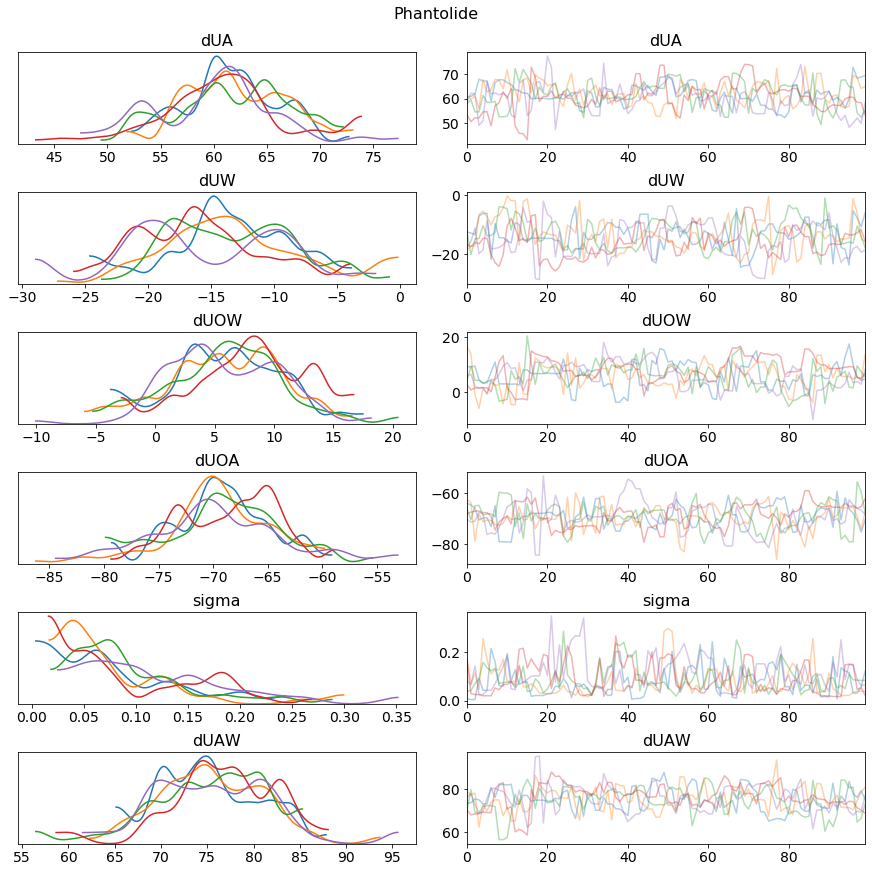

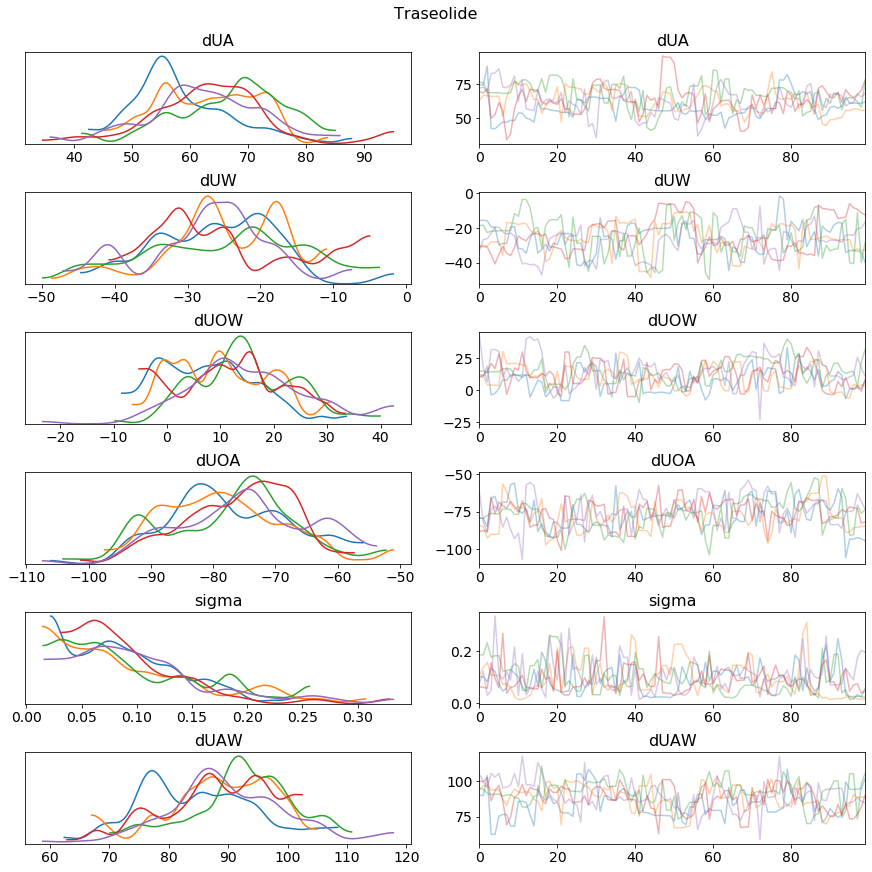

In [12]:
#Check the traceplots
directory = "Traces/"
#Loop through all the files in the "Traces" directory and display plots. You may want to change the directory to a
#sub-folder if you are running lots of compounds. This may take ~minutes for lots of plots
for filename in os.listdir(directory):
    #Define the compound from the filename
    #pdb.set_trace()
    comp = filename[0:filename.find("_")]
    if comp == "benzokfluoranthene": #Error from the square brackets in loading files
        comp = "benzo[k]fluoranthene"
    elif comp == "benzoapyrene":
        comp = "benzo[a]pyrene"
    try: 
        fig, tracesumm = fmf.plot_trace(comp,FAVs,filename=directory+filename,uDV=uLDV,model_type = 'dU')
        #Put it in the FAV dataframe at the same time, just in case the kernel was reloaded at some point.
        FAVs = fmf.trace_to_FAVs(comp,FAVs,filename = directory+filename,uDV=uLDV,model_type='dU')
        #Print the compound name and the traceplot summary tables
        comp
        tracesumm
    except KeyError:
        #Subfolders in the directory will return a keyerror.
        pass

In [35]:
#Restore the interactive shell.
InteractiveShell.ast_node_interactivity = 'last_expr'   

Unfortunately, that is all we can do with internal energies as we can't get a consistent system for any
of the other compounds. Soon, we will supplement this dataset with in silico estimations
and come back to make recommended FAVs (FAVRs) for all compounds. First, we will look at the adjustements and the misclosure errors of the FAVs to ensure that everything converged. Then we will export the dU FAVLs to a CSV file.

In [16]:
#Look at the adjustments
comps = FAVs.loc[FAVs.loc[:,'dUA']!=0,:].index
dUnames = ['dUA','dUW','dUO','dUAW','dUOW','dUOA']
for prop in dUnames:
    FAVs.loc[comps,'e_'+prop] = uLDV.loc[comps,prop]-FAVs.loc[comps,prop] 
#Display
FAVs.loc[comps,'e_dUA':'e_dUOA']

e_dUA       e_dUW       e_dUO                    e_dUAW  \
Compound Name                                                                  
Musk Ambrette     -10+/-11     20+/-19     nan+/-0   nan+/-10.87300746791531   
Phantolide           7+/-7      -6+/-8     nan+/-0   nan+/-5.881241137121716   
Traseolide         12+/-11    -11+/-15     nan+/-0   nan+/-9.884059035171134   
Galaxolide 1    -0.6+/-2.7       9+/-8     nan+/-0  nan+/-2.8009951316088717   
Musk Tibetene       -6+/-8       8+/-9     nan+/-0   nan+/-4.138823784455233   
p,p'- DDE        3.1+/-3.4      33+/-7  -3.1+/-2.7                   nan+/-0   
o,p'-DDT        -2.3+/-2.0  10.5+/-2.1   0.6+/-1.4                   nan+/-0   
benzo[a]pyrene      -7+/-9     -3+/-11       1+/-4   nan+/-5.067161745898574   
BDE-47               3+/-6      -1+/-4     nan+/-0   nan+/-4.838053149554705   
PCB-209         -0.2+/-1.5       8+/-9     nan+/-0   nan+/-4.988273328883778   

                   e_dUOW      e_dUOA  
Compound Name                          
Musk Ambrette     10+/-11      -2+/-6  
Phantolide         -6+/-5       7+/-8  
Traseolide       -12+/-10     12+/-11  
Galaxolide 1    1.4+/-2.6  -0.4+/-1.4  
Musk Tibetene       2+/-4  -0.4+/-2.5  
p,p'- DDE         nan+/-0       3+/-4  
o,p'-DDT          nan+/-0  -0.5+/-1.1  
benzo[a]pyrene     -0+/-7      -1+/-4  
BDE-47             -0+/-6       1+/-6  
PCB-209             3+/-6      -5+/-8

In [3]:
#Then we export the FAVs to a CSV file in the parent directory. Change the savename to include a folder if you want
#to save in a specific folder.
dUFAVLs_exp = fmf.export_FAVs(FAVs,savename = 'FAVLs_dU')

## Step 2: Estimate FAVRs for the internal energies
Now (in a different application or by insterting cells here), pick your favourite in silico estimations and construct a set of internal energy values without any missing properties. On the Excel template enter the chosen in silico estimations into the "Table S9 Model Derived Values" worksheet, then save the output from the "LDV_MDV Output" sheet for importing (the default name "LDVMDV_Data.xlsx", to modify you can overwrite that sheet). For Rodgers et al. (2021), we did not have a reliable in silico estimation of dUo, so we constructed a set of values that was missing only dUo. We will assume that is the case for this tutorial.

In [7]:
#Load the data. I am going to use CDV here as "Combined Derived Values", consisting of LDVs and MDVs
CDV = pd.read_excel('LDVMDV_Data.xlsx', index_col = 2)
uCDV,FAVRs = fmf.loaddata(CDV)
#Display the header column of the uLDV.
uCDV.head()

dVAPH        dUW     dUO         dUOA     dUAW  \
Compound Name                                                             
cyclopentadecanone     65+/-12  1.5+/-1.3   3+/-4  -35.5+/-2.2  69+/-12   
15-pentadecanolide  77.0+/-2.5      5+/-4   4+/-6     -76+/-25  71+/-12   
Musk Ambrette           80+/-6    48+/-14  9+/-13  -69.0+/-2.8  76+/-13   
16-hexadecanolide      73+/-10      8+/-7   4+/-6  -52.3+/-3.3  74+/-13   
Celestolide            79+/-20    -22+/-7   3+/-5      -65+/-4  76+/-13   

                             dUOW       LogKOA       LogKOW        LogKAW  \
Compound Name                                                               
cyclopentadecanone      1.2+/-2.3  6.59+/-0.17    5.7+/-1.1  -0.72+/-0.30   
15-pentadecanolide     -0.6+/-1.2    8.6+/-1.1    5.8+/-0.6  -0.40+/-0.17   
Musk Ambrette           2.5+/-0.7  8.03+/-0.11  4.21+/-0.29    -4.7+/-2.0   
16-hexadecanolide          -4+/-7  7.31+/-0.19    7.3+/-1.5  -0.33+/-0.14   
Celestolide         0.059+/-0.018  7.58+/-0.20    5.7+/-1.1    -2.0+/-0.8   

                           LogPL  ...    w_dUAW   w_dUOW   w_dUOA   w_dUij  \
Compound Name                     ...                                        
cyclopentadecanone    -0.3+/-0.4  ...   -8+/-17    0+/-5  25+/-13  32+/-12   
15-pentadecanolide  -1.08+/-0.06  ...   -1+/-13    0+/-7  -6+/-26  -5+/-28   
Musk Ambrette       -1.23+/-0.19  ...  -47+/-20  42+/-19  -1+/-14   4+/-13   
16-hexadecanolide     -1.1+/-0.4  ...  -11+/-17   0+/-11  15+/-12  26+/-15   
Celestolide         -0.78+/-0.12  ...   22+/-25  -25+/-8   8+/-21  11+/-14   

                          w_Ks          w4          w5       w_KAW  \
Compound Name                                                        
cyclopentadecanone   0.2+/-1.2  -0.3+/-1.3  -0.7+/-1.6  -0.6+/-0.6   
15-pentadecanolide   2.4+/-1.3   1.2+/-1.3   0.8+/-1.4  -1.2+/-0.4   
Musk Ambrette       -0.9+/-2.0   1.7+/-0.5   1.8+/-0.5   2.6+/-2.0   
16-hexadecanolide   -0.3+/-1.5  -1.2+/-1.6  -2.2+/-2.1  -0.9+/-0.6   
Celestolide         -0.1+/-1.4  -0.9+/-1.2  -1.4+/-1.6  -0.8+/-0.9   

                         w_KOW       w_KOA  
Compound Name                               
cyclopentadecanone  -0.9+/-1.4  -1.2+/-0.9  
15-pentadecanolide  -1.4+/-1.0  -0.2+/-1.4  
Musk Ambrette       -1.0+/-0.6   0.7+/-0.5  
16-hexadecanolide   -0.4+/-1.7  -1.6+/-0.9  
Celestolide          0.7+/-1.3  -0.2+/-0.7  

[5 rows x 59 columns]

In [5]:
#Check that compounds are missing at most one property. In the example data, three compounds have measured dUOs
numUs_absent = 1
uCDV.loc[uCDV.nUs_absent>numUs_absent,'dUA_absent':'dUOA_absent']
#Empty - so they are all missing one or fewer properties

Empty DataFrame
Columns: [dUA_absent, dUW_absent, dUO_absent, dUAW_absent, dUOW_absent, dUOA_absent]
Index: []

In [14]:
#Define the compounds that will be tried - here we loop through everything. Note that for me looping through 
#all 74 compounds with 20k samples (10k tune + 10k trace) takes several days.
numUs_absent = 3
comps = ['TiBP','TnBP','TPPO','B4tBPPP']#'uCDV.index
#If you want to run a specific compound/list of compounds, comment out the above line and run the following:
comps = ['Musk Ambrette']
for comp in comps:
    #pdb.set_trace()
    #For some compounds we can't make an FAV. This will raise a "ValueError", and we will skip that compound.
    try:
        FAVRs, enth_trace = fmf.run_model(comp,FAVRs,model_type ='dU',uDV = uCDV,savepath = 'Traces/FAVRs/dUs/',
                                          trace = 500, tune=500,target_accept=0.9)
        #FAVs, enth_trace = fmf.run_model(comp,FAVRs,model_type ='dU',uDV = uLDV,trace = 100,
        #                                 tune=100,target_accept=0.9)
    
    except ValueError:
        pass

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(-2.30258509), 'dUA': array(77.109), 'dUW': array(48.03783666), 'dUO': array(8.684865), 'dUAW': array(76.0268797), 'dUOW': array(2.4963375), 'dUOA': array(-69.05)}

Initial evaluation results:
sigma_log__    -0.73
dUA            -3.67
dUW            -3.67
dUO             -inf
dUAW            -inf
dUOW           -3.67
dUOA           -2.98
Y_obs         -57.35
Name: Log-probability of test_point, dtype: float64

In [12]:
uCDV.loc[comp,:]

[dVAPH                                80+/-6
 dUW                                 48+/-14
 dUO                                     NaN
 dUOA                            -69.0+/-2.8
 dUAW                                    NaN
 dUOW                              2.5+/-0.7
 LogKOA                          8.03+/-0.11
 LogKOW                          4.21+/-0.29
 LogKAW                                  NaN
 LogPL                          -1.23+/-0.19
 LogSW                          -2.47+/-0.31
 LogSO                                   NaN
 dfusS                                   NaN
 Tm                               85.2+/-0.5
 dVAPH_NumVals                           1.0
 dUW_NumVals                             1.0
 dUO_NumVals                             NaN
 dUOA_NumVals                            2.0
 dUAW_NumVals                            NaN
 dUOW_NumVals                            1.0
 LogKOA_NumVals                          2.0
 LogKOW_NumVals                          1.0
 LogKAW_Nu

In [ ]:
#Check the traceplots
directory = 'Traces/FAVRs/dUs/'
#Loop through all the files in the directory and display plots. You may want to change the directory to a
#sub-folder if you are running lots of compounds. This may take ~minutes for lots of plots
for filename in os.listdir(directory):
    #Define the compound from the filename
    #pdb.set_trace()
    comp = filename[0:filename.find("_")]
    if comp == "benzokfluoranthene": #Error from the square brackets in loading files
        comp = "benzo[k]fluoranthene"
    elif comp == "benzoapyrene":
        comp = "benzo[a]pyrene"
    try: 
        fig, tracesumm = fmf.plot_trace(comp,FAVRs,filename=directory+filename,uDV=uCDV,model_type = 'KS')
        #Put it in the FAV dataframe at the same time, just in case the kernel was reloaded at some point.
        FAVRs = fmf.trace_to_FAVs(comp,FAVRs,filename = directory+filename,uDV=uCDV,model_type='KS')
        #Print the compound name and the traceplot summary tables
        comp
        tracesumm
    except KeyError:
        #Subfolders in the directory will return a keyerror.
        pass

In [7]:
#InteractiveShell.ast_node_interactivity = 'all'
InteractiveShell.ast_node_interactivity = 'last_expr'  

In [ ]:
#Look at the adjustments
comps = FAVRs.loc[FAVRs.loc[:,'dUA']!=0,:].index
dUnames = ['dUA','dUW','dUO','dUAW','dUOW','dUOA']
for prop in dUnames:
    FAVRs.loc[comps,'e_'+prop] = uLDV.loc[comps,prop]-FAVRs.loc[comps,prop] 
#Display
FAVRs.loc[comps,'e_dUA':'e_dUOA']

In [ ]:
#Then we export the FAVs to a CSV file in the parent directory. Change the savename to include a folder if you want
#to save in a specific folder.
dUFAVRs_exp = fmf.export_FAVs(FAVRs,savename = 'FAVRs_dU')

Finally, we are done with the internal energies! Next we will do the partition coefficients and solubilities
in a separate Jupyter notebook, for convenience. You can use the FAVRs generated here for the internal
energies to temperature-correct any literature values you may have found not at 25°C for the partition 
coefficients and solubilities. The Excel template "Table S4" has equations that will pull from "Table S6"